# Data visualization and pre-processing

## Data visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyarrow.parquet as pq
import polars as pl

In [2]:
train_events = pd.read_csv('../../train_events.csv')

#Read file with chunks
#chunksize = 100000
#train_series = pq.ParquetFile('../../train_series.parquet')
#for batch in train_series.iter_batches(batch_size=chunksize):
#    train_series_chunk = batch.to_pandas()

train_series = pd.read_csv('../../filtered_train_series.csv')

test_series = pq.read_table('../../test_series.parquet').to_pandas()

### Train events visualization

In [7]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [8]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_events.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")


Nombre de valeurs manquantes par colones:
series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


In [9]:
num_duplicates = train_events.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")


Nombre de lignes dupliquées : 0


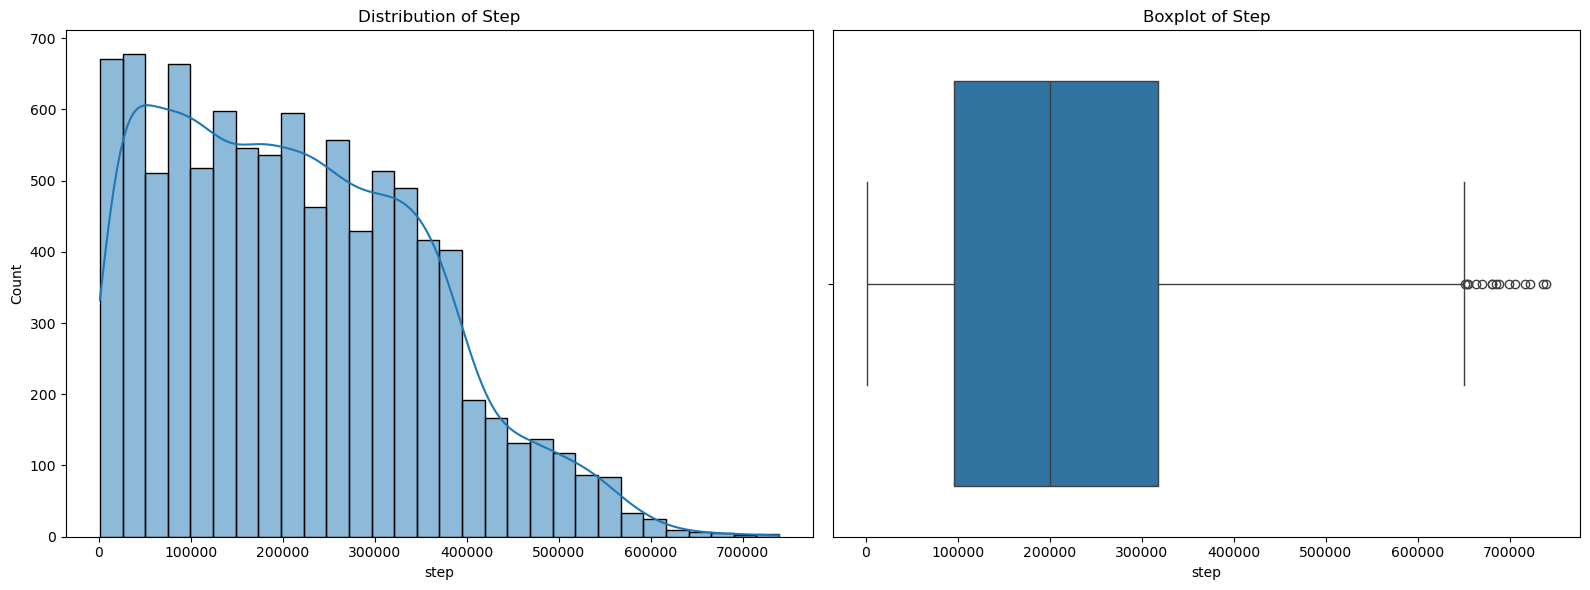

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Histogramme pour la colonne "step"
sns.histplot(train_events['step'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Step')

# Boxplot pour identifier les outliers
sns.boxplot(x=train_events['step'], ax=axes[1])
axes[1].set_title('Boxplot of Step')

# Afficher les graphiques
plt.tight_layout()
plt.show()


On observe une majorité d'événements qui se produisent pour des steps entre 0 et 4000000. Puis après une très grosse baisse d'événements graduelle.

Le boxplot nous montre une médiane centrée sur 200000 steps. On remarque aussi quelques outliers à partir de 650000 steps.

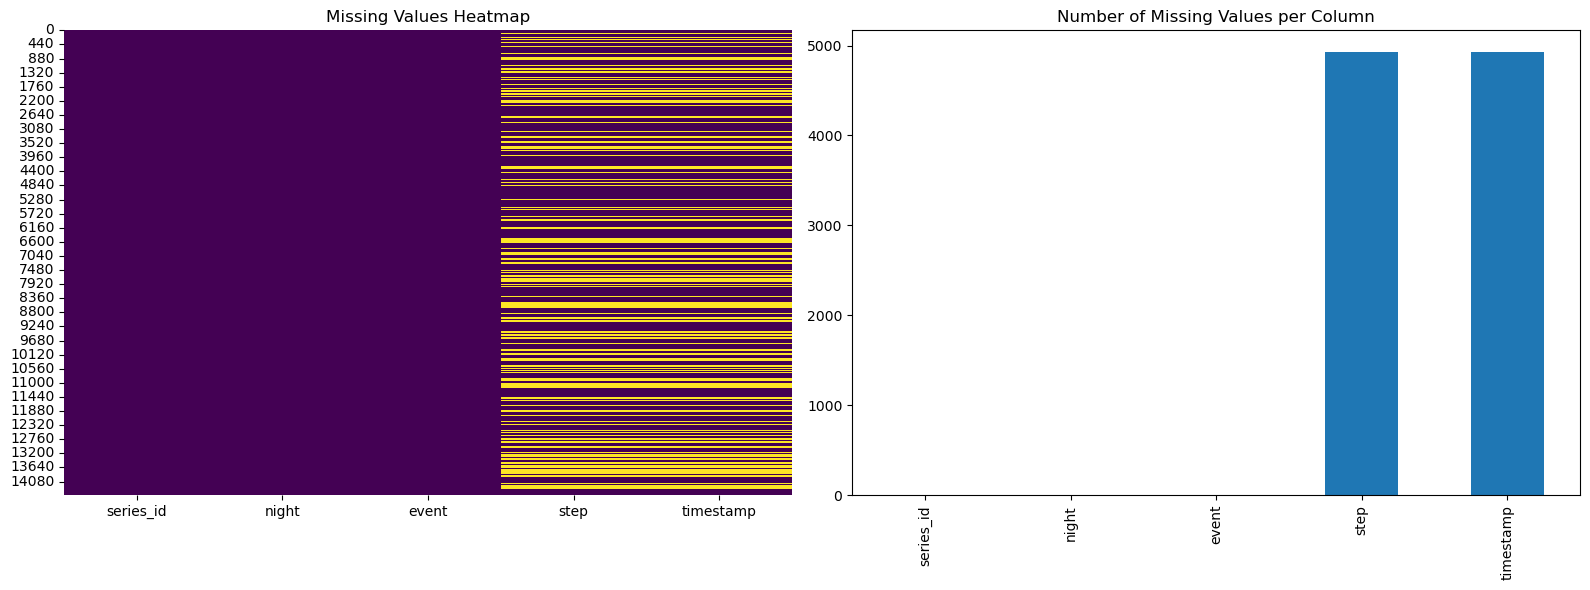

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualisation des valeurs manquantes (Heatmap)
sns.heatmap(train_events.isna(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Nombre de valeurs NaN par colonne (Barplot)
train_events.isna().sum().plot(kind='bar', ax=axes[1])
axes[1].set_title('Number of Missing Values per Column')

# Afficher les graphiques
plt.tight_layout()
plt.show()


On voit que les valeurs manquantes sont seulements sur les colonnes step et timestamp (colonnes numériques). Les valeurs manquantes semblent être réparties uniformément dans tout le jeu de données selon la heatmap et aussi simultanement pour step et timestamp

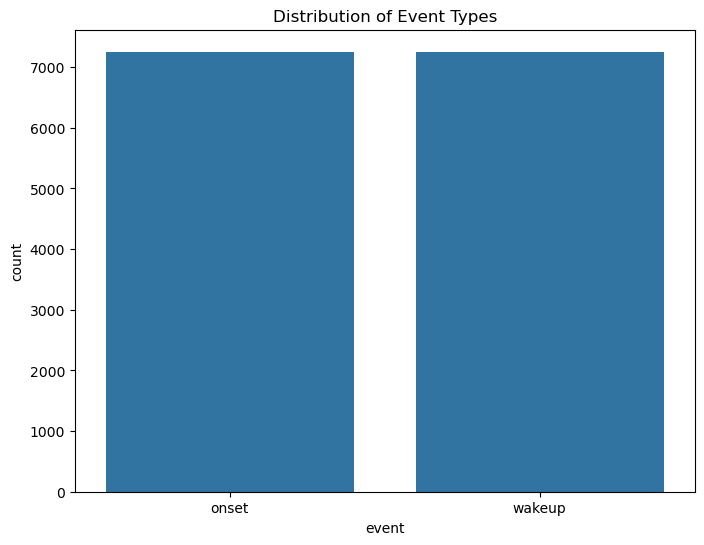

In [12]:
# Compter la fréquence des différents types d'événements
plt.figure(figsize=(8, 6))
sns.countplot(x='event', data=train_events)
plt.title('Distribution of Event Types')
plt.show()

IL y a autant d'événements onset que wakeup

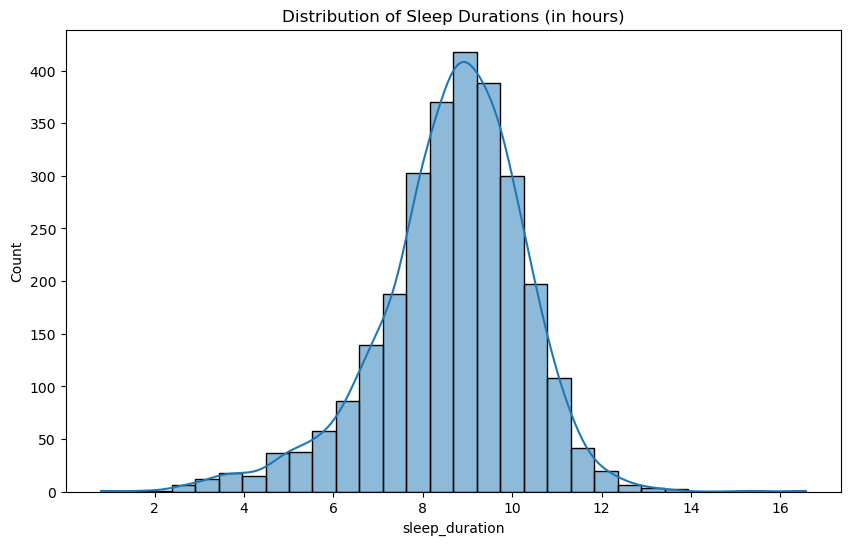

In [6]:
# Convertir les timestamps en datetime dans le DataFrame d'origine
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Créer des DataFrames séparés pour les événements 'onset' et 'wakeup'
onset_df = train_events[train_events['event'] == 'onset']
wakeup_df = train_events[train_events['event'] == 'wakeup']

# Fusionner onset et wakeup sur 'series_id' et 'night' pour chaque nuit
sleep_durations = pd.merge(onset_df, wakeup_df, on=['series_id', 'night'], suffixes=('_onset', '_wakeup'))

# Assurer que les colonnes timestamp sont bien de type datetime
sleep_durations['timestamp_onset'] = pd.to_datetime(sleep_durations['timestamp_onset'], errors='coerce')
sleep_durations['timestamp_wakeup'] = pd.to_datetime(sleep_durations['timestamp_wakeup'], errors='coerce')

# Calculer la durée de chaque nuit en heures
sleep_durations['sleep_duration'] = (sleep_durations['timestamp_wakeup'] - sleep_durations['timestamp_onset']).dt.total_seconds() / 3600

# Visualisation des durées de sommeil
plt.figure(figsize=(10, 6))
sns.histplot(sleep_durations['sleep_duration'], bins=30, kde=True)
plt.title('Distribution of Sleep Durations (in hours)')
plt.show()



La durée de sommeil semble suivre une loi normale centrée autour de 9h de sommeil.

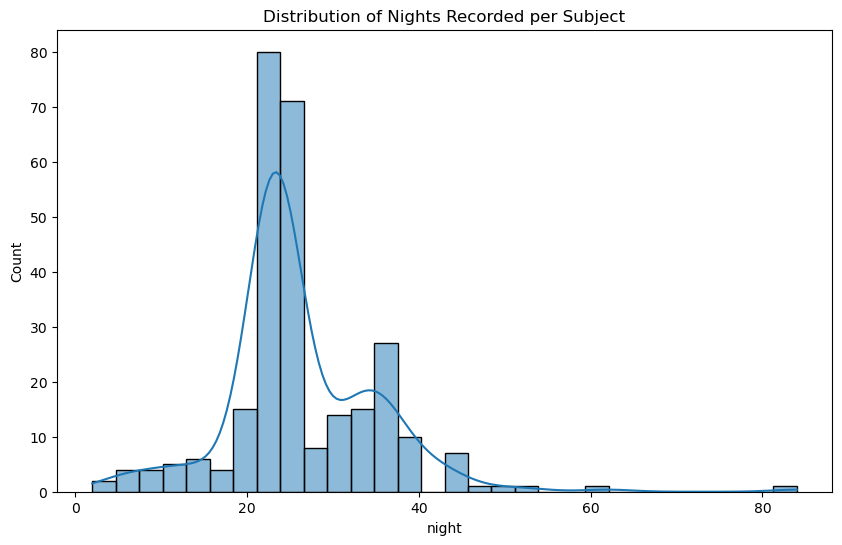

In [4]:
# Nombre de nuits par sujet
nights_per_subject = train_events.groupby('series_id')['night'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(nights_per_subject, bins=30, kde=True)
plt.title('Distribution of Nights Recorded per Subject')
plt.show()


Les sujets semblent faire en moyenne un peu plus entre 20 et 30 nuits.

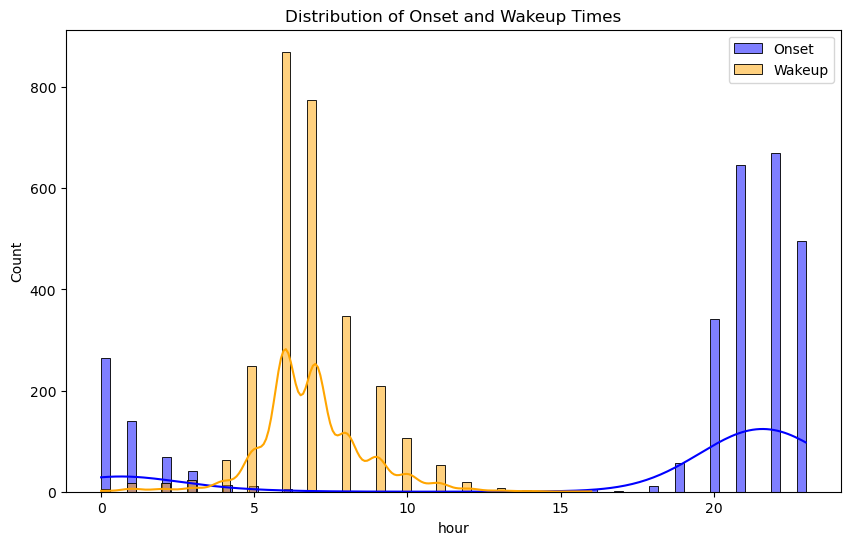

In [7]:
# Convertir les timestamps en datetime s'ils ne le sont pas déjà
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], errors='coerce')

# Extraire l'heure des timestamps pour les événements onset et wakeup
train_events['hour'] = train_events['timestamp'].dt.hour

# Visualisation des heures d'onset et wakeup
plt.figure(figsize=(10, 6))
sns.histplot(train_events[train_events['event'] == 'onset']['hour'], color='blue', label='Onset', kde=True)
sns.histplot(train_events[train_events['event'] == 'wakeup']['hour'], color='orange', label='Wakeup', kde=True)
plt.title('Distribution of Onset and Wakeup Times')
plt.legend()
plt.show()


On distingue bien le contraste de distribution des temps d'onset et de Wakeup

### Train series visualization

In [8]:
train_series

,series_id,step,timestamp,anglez,enmo,event
0,038441c925bb,85,2018-08-14 19:37:05+00:00,-79.9769,0.0129,0
1,038441c925bb,123,2018-08-14 19:40:15+00:00,-80.2026,0.0129,0
2,038441c925bb,313,2018-08-14 19:56:05+00:00,-82.3155,0.0156,0
3,038441c925bb,333,2018-08-14 19:57:45+00:00,-82.3025,0.0142,0
4,038441c925bb,419,2018-08-14 20:04:55+00:00,-83.4873,0.0149,0
...,...,...,...,...,...,...
1288750,fe90110788d2,591647,2017-09-08 03:13:55+00:00,49.3486,0.0045,0
1288751,fe90110788d2,591776,2017-09-08 03:24:40+00:00,11.3838,0.0000,0
1288752,fe90110788d2,591817,2017-09-08 03:28:05+00:00,15.7196,0.0000,0
1288753,fe90110788d2,592189,2017-09-08 03:59:05+00:00,15.7196,0.0000,0


In [10]:
# Calculer le nombre de valeurs NaN par colonne
nan_counts = train_series.isna().sum()

# Afficher le résultat
print(f"Nombre de valeurs manquantes par colones:\n{nan_counts}")


Nombre de valeurs manquantes par colones:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
event        0
dtype: int64


In [11]:
num_duplicates = train_events.duplicated().sum()
print(f"Nombre de lignes dupliquées : {num_duplicates}")

Nombre de lignes dupliquées : 0
